In [1]:
!pip install imbalanced-learn

In [2]:
!pip install -q shap

In [3]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from imblearn.over_sampling import SMOTE

import shap

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
#Load Data
df = pd.read_csv('term-deposit-marketing-2020-cleaned.csv')
#Let's fill in missing data for contact
df = df.replace(np.nan,'unknown')

In [6]:
#set random seed
np.random.seed(100)
torch.manual_seed(100)

In [7]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [9]:
#encode output class
df['y'] = df['y'].astype('category')
encode_map = {'yes': 1, 'no': 0}
df['y'].replace(encode_map, inplace=True)

In [10]:
#encode binary input class
df['default'] = df['default'].astype('category')
df['housing'] = df['housing'].astype('category')
df['loan'] = df['loan'].astype('category')
encode_map = {'yes': 1, 'no': 0}
df['default'].replace(encode_map, inplace=True)
df['housing'].replace(encode_map, inplace=True)
df['loan'].replace(encode_map, inplace=True)

In [11]:
#encode the rest of input class
col_name = ['job','marital','education','contact','month']
for col in col_name:
  df[col] = df[col].astype('category')
  df[col] = df[col].cat.codes

In [12]:
#create input and output classs
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [13]:
#Use SMOTE for fix imbalance dataset
# transform the dataset
oversample = SMOTE(random_state=42)
X, y = oversample.fit_resample(X, y)

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.


In [14]:
#Train test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5)

X_rem, X_test, y_rem, y_test = train_test_split(X,y, test_size=0.1)
X_val, X_train, y_val, y_train = train_test_split(X_rem,y_rem, test_size=0.5)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(33394, 13)
(33394,)
(33393, 13)
(33393,)
(7421, 13)
(7421,)


In [15]:
#standardize input
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [16]:
#set model paramenters
EPOCHS = 30
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [17]:
## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train))

In [18]:
## validation data
class valData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


val_data = valData(torch.FloatTensor(X_val), 
                       torch.FloatTensor(y_val))

In [19]:
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test))

In [20]:
#initialize dataloader
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset=val_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [21]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 13.
        self.layer_1 = nn.Linear(13, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [22]:
#check to see if gpu is active
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [23]:
#initialize optimizer and decide on which loss function to use.
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=13, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [24]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [25]:
train_loss_ls = []
train_acc_ls = []
val_loss_ls = []
val_acc_ls = []
for e in range(1, EPOCHS+1):
    train_loss = 0
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    val_loss = 0

    model.eval() 
    for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        
        val_loss += loss.item()

    print(f'Epoch {e+0:03}: | Train Loss: {train_loss/len(train_loader):.5f} | Val Loss: {val_loss/len(val_loader):.5f}')
    train_loss_ls.append(train_loss/len(train_loader))
    val_loss_ls.append(val_loss/len(val_loader))

    if ((e > 4) and (val_loss_ls[-1] > val_loss_ls[-2]) and (val_loss_ls[-1] > val_loss_ls[-3]) and (val_loss_ls[-1] > val_loss_ls[-4])):
      break

Epoch 001: | Train Loss: 0.31840 | Val Loss: 0.27531
Epoch 002: | Train Loss: 0.27628 | Val Loss: 0.26166
Epoch 003: | Train Loss: 0.26291 | Val Loss: 0.25435
Epoch 004: | Train Loss: 0.25151 | Val Loss: 0.24675
Epoch 005: | Train Loss: 0.24288 | Val Loss: 0.24230
Epoch 006: | Train Loss: 0.23671 | Val Loss: 0.24015
Epoch 007: | Train Loss: 0.23209 | Val Loss: 0.23743
Epoch 008: | Train Loss: 0.22788 | Val Loss: 0.23526
Epoch 009: | Train Loss: 0.22264 | Val Loss: 0.23350
Epoch 010: | Train Loss: 0.21839 | Val Loss: 0.23153
Epoch 011: | Train Loss: 0.21531 | Val Loss: 0.22903
Epoch 012: | Train Loss: 0.21151 | Val Loss: 0.22831
Epoch 013: | Train Loss: 0.20869 | Val Loss: 0.22626
Epoch 014: | Train Loss: 0.20600 | Val Loss: 0.22484
Epoch 015: | Train Loss: 0.20205 | Val Loss: 0.22439
Epoch 016: | Train Loss: 0.19889 | Val Loss: 0.22333
Epoch 017: | Train Loss: 0.19750 | Val Loss: 0.22153
Epoch 018: | Train Loss: 0.19528 | Val Loss: 0.22364
Epoch 019: | Train Loss: 0.19273 | Val Loss: 0

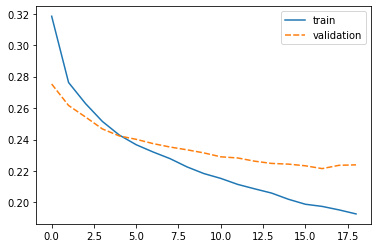

In [26]:
loss = pd.DataFrame(
    {'train': train_loss_ls,
     'validation': val_loss_ls,
    })
sns.lineplot(data=loss);

In [27]:
#Test model
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [28]:
cm = confusion_matrix(y_test, y_pred_list)
print(cm)

[[3252  411]
 [ 233 3525]]


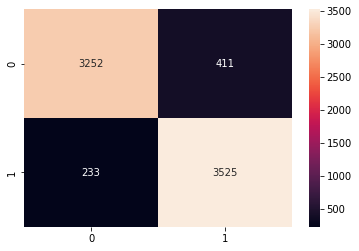

In [29]:
f = sns.heatmap(cm, annot=True, fmt='g')

In [30]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      3663
           1       0.90      0.94      0.92      3758

    accuracy                           0.91      7421
   macro avg       0.91      0.91      0.91      7421
weighted avg       0.91      0.91      0.91      7421

